Data source: https://archive.ics.uci.edu/dataset/222/bank+marketing  

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).  


### Input variables

**bank client data:**  
   1 - `age` (numeric)  
   2 - `job` : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
   3 - `marital` : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)  
   4 - `education` (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  
   5 - `default`: has credit in default? (categorical: 'no','yes','unknown')  
   6 - `housing`: has housing loan? (categorical: 'no','yes','unknown')  
   7 - `loan`: has personal loan? (categorical: 'no','yes','unknown')  

**related with the last contact of the current campaign:**  
   8 - `contact`: contact communication type (categorical: 'cellular','telephone')  
   9 - `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
  10 - `day_of_week`: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')  
  11 - `duration`: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and **should be discarded if the intention is to have a realistic predictive model**.  

**other attributes:**  
  12 - `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  13 - `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric; **999 means client was not previously contacted**)  
  14 - `previous`: number of contacts performed before this campaign and for this client (numeric)  
  15 - `poutcome`: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')  

**social and economic context attributes**  
  16 - `emp.var.rate`: employment variation rate - quarterly indicator (numeric)  
  17 - `cons.price.idx`: consumer price index - monthly indicator (numeric)  
  18 - `cons.conf.idx`: consumer confidence index - monthly indicator (numeric)     
  19 - `euribor3m`: euribor 3 month rate - daily indicator (numeric)  
  20 - `nr.employed`: number of employees - quarterly indicator (numeric)  

### Output variable (desired target):

  21 - `y` - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_theme()
sns.set_palette('Set2')
pd.set_option('display.max_columns', 21)

In [2]:
# read data
data = pd.read_csv('https://raw.githubusercontent.com/JielingChen/bank_marketing/main/bank-additional.csv', sep=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [3]:
# rename columns to more informative names
data = data.rename(columns={'contact': 'contact_type',
                            'campaign': 'camp_nr_contacts',
                            'previous': 'pre_camp_nr_contacts',
                            'poutcome': 'pre_camp_outcome',
                            'y': 'subscribed'})

In [4]:
# check missing values and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   4119 non-null   int64  
 1   job                   4119 non-null   object 
 2   marital               4119 non-null   object 
 3   education             4119 non-null   object 
 4   default               4119 non-null   object 
 5   housing               4119 non-null   object 
 6   loan                  4119 non-null   object 
 7   contact_type          4119 non-null   object 
 8   month                 4119 non-null   object 
 9   day_of_week           4119 non-null   object 
 10  duration              4119 non-null   int64  
 11  camp_nr_contacts      4119 non-null   int64  
 12  pdays                 4119 non-null   int64  
 13  pre_camp_nr_contacts  4119 non-null   int64  
 14  pre_camp_outcome      4119 non-null   object 
 15  emp.var.rate         

* These is no missing values in the dataset.

In [5]:
# cross field validation
data[(data['pre_camp_nr_contacts'] == 0) & (data['pre_camp_outcome'] != 'nonexistent')]

,age,job,marital,education,default,housing,loan,contact_type,month,day_of_week,duration,camp_nr_contacts,pdays,pre_camp_nr_contacts,pre_camp_outcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed


In [6]:
# check the summary statistics of numerical variables
num = data.select_dtypes(exclude=['object'])
num.describe()

,age,duration,camp_nr_contacts,pdays,pre_camp_nr_contacts,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
# check the summary statistics of categorical variables
cat = data.select_dtypes(include=['object'])
cat.describe()

,job,marital,education,default,housing,loan,contact_type,month,day_of_week,pre_camp_outcome,subscribed
count,4119,4119,4119,4119,4119,4119,4119,4119,4119,4119,4119
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,1012,2509,1264,3315,2175,3349,2652,1378,860,3523,3668


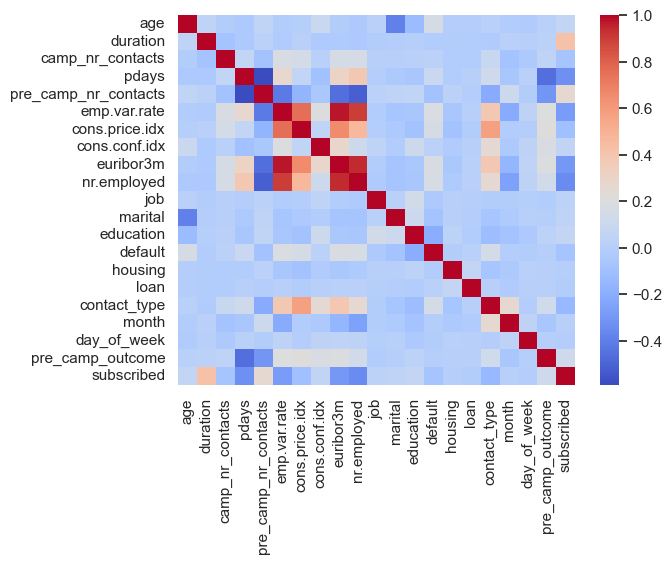

In [8]:
# encode categorical variables to integers and plot the correlation matrix
cat_encoded = cat.apply(lambda x: x.astype('category').cat.codes)
corr = pd.concat([num, cat_encoded], axis=1).corr()
sns.heatmap(corr, cmap='coolwarm')
plt.show()

In [9]:
# print the highly correlated variables
high_corr = corr[(abs(corr) >= 0.8) & (corr != 1)]
high_corr = high_corr.stack().reset_index()
high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]
high_corr = high_corr.drop_duplicates(subset=[0])
high_corr = high_corr.rename(columns={'level_0': 'var1', 
                                      'level_1': 'var2', 
                                      0: 'corr'}).reset_index(drop=True)
high_corr

,var1,var2,corr
0,emp.var.rate,euribor3m,0.970308
1,emp.var.rate,nr.employed,0.897173
2,euribor3m,nr.employed,0.942589


In [10]:
# print the moderately correlated variables
moderate_corr = corr[(abs(corr) >= 0.6) & (abs(corr) < 0.8)]
moderate_corr = moderate_corr.stack().reset_index()
moderate_corr = moderate_corr[moderate_corr['level_0'] != moderate_corr['level_1']]
moderate_corr = moderate_corr.drop_duplicates(subset=[0])
moderate_corr = moderate_corr.rename(columns={'level_0': 'var1', 
                                              'level_1': 'var2', 
                                              0: 'corr'}).reset_index(drop=True)
moderate_corr

,var1,var2,corr
0,emp.var.rate,cons.price.idx,0.755155
1,cons.price.idx,euribor3m,0.657159


**Highly correlated features include:**
* euribor 3 month rate, employment variation rate and number of employees.

**Moderately correlated features include:**
* euribor 3 month rate, employment variation rate and consumer price index.

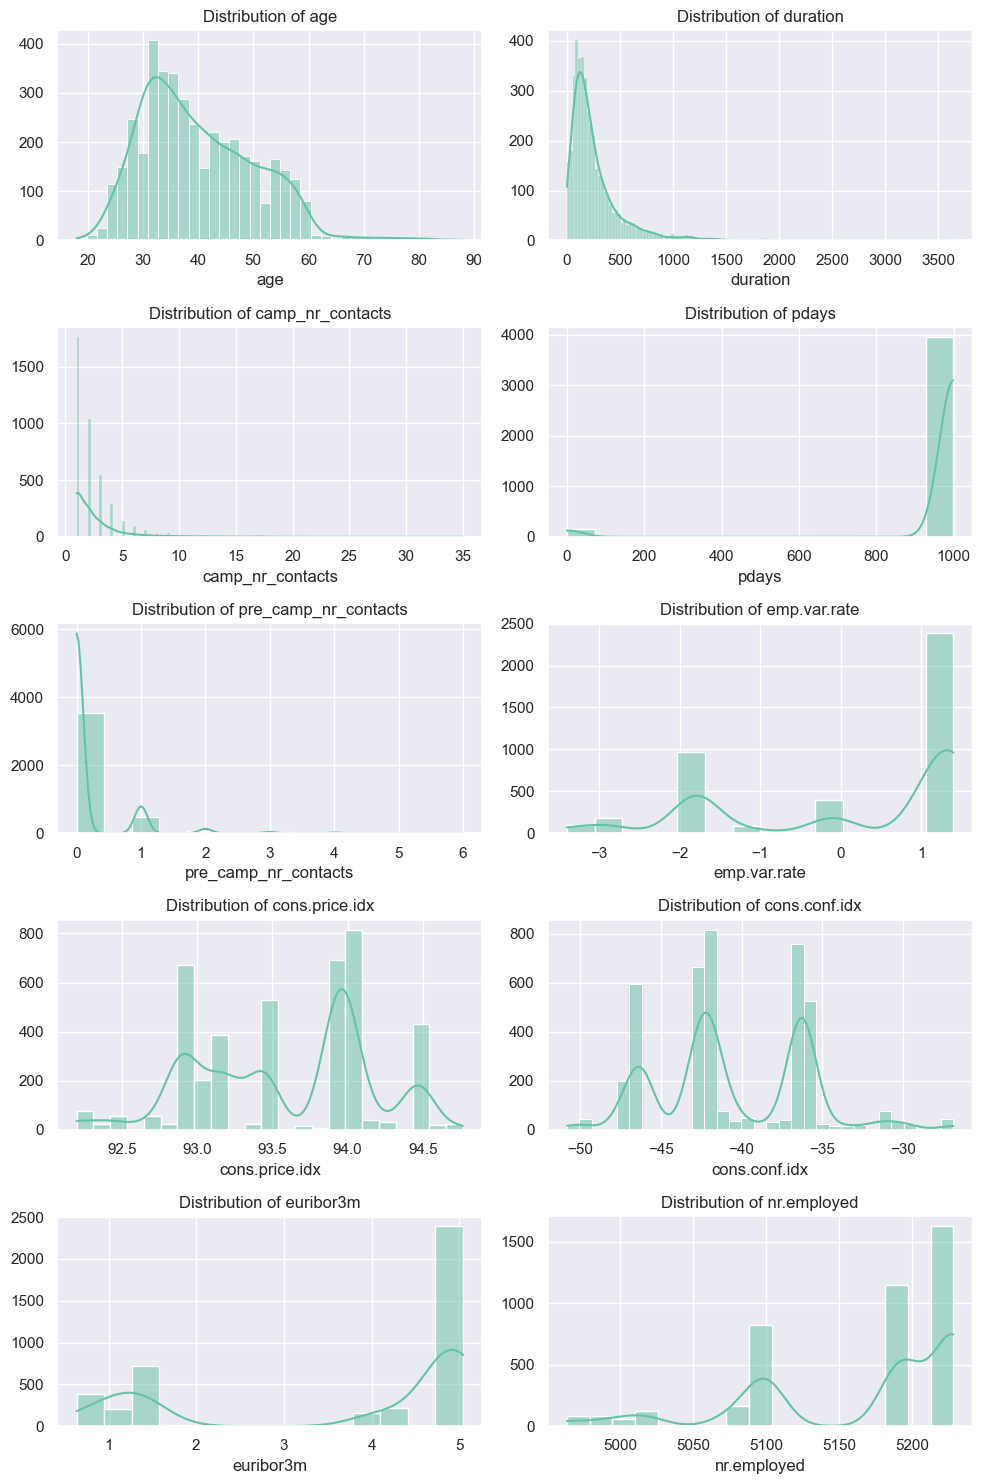

In [11]:
# plot the distribution of numerical variables
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
num_cols = num.columns
for i, ax in enumerate(axes.flatten()):
    sns.histplot(num[num_cols[i]], ax=ax, kde=True)
    ax.set_title(f'Distribution of {num_cols[i]}')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

* The customers are mainly middle-age.
* `pdays` is almost binary and is highly correlated with `pre_campaign_nr_contacts`, so I drop this column.
* The `duration` and `camp_nr_contacts` are right-skewed - number of contacts performed during this campaign and for a client is small and the duration of contact are mostly short.

In [12]:
# drop pdays
data.drop('pdays', axis=1, inplace=True)

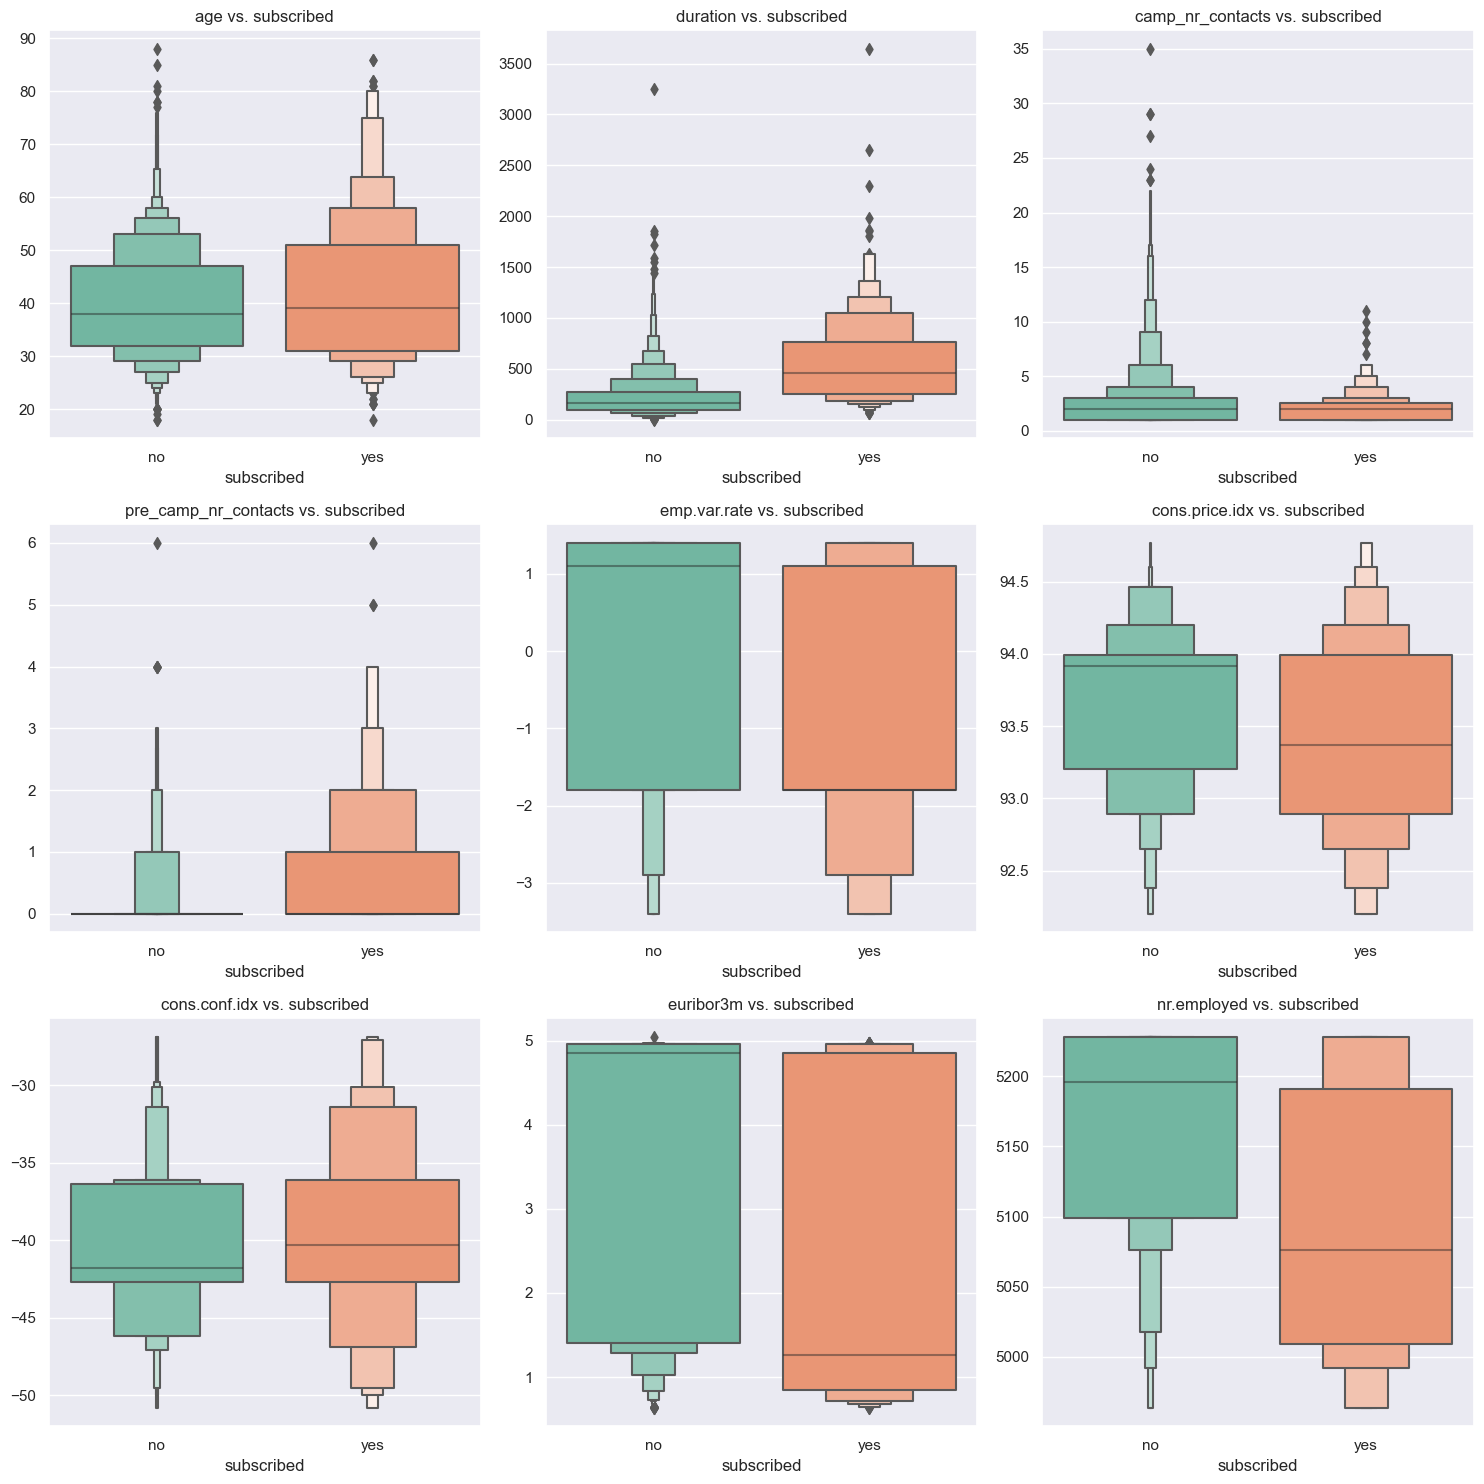

In [13]:
# plot the boxenplot of numerical variables vs. y
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
cols = data.select_dtypes(exclude=['object', 'category']).columns
for i, ax in enumerate(axes.flatten()):
    sns.boxenplot(x='subscribed', y=cols[i], data=data, ax=ax)
    ax.set_title(f'{cols[i]} vs. subscribed')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [14]:
# map the month to integer for time series analysis
data['month'] = data['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun':6,
                                   'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec':12})

In [15]:
# binary encode the target variable
data['subscribed'] = data['subscribed'].map({'no': 0, 'yes': 1})
# check the subscription rate
data['subscribed'].mean().round(4)

0.1095

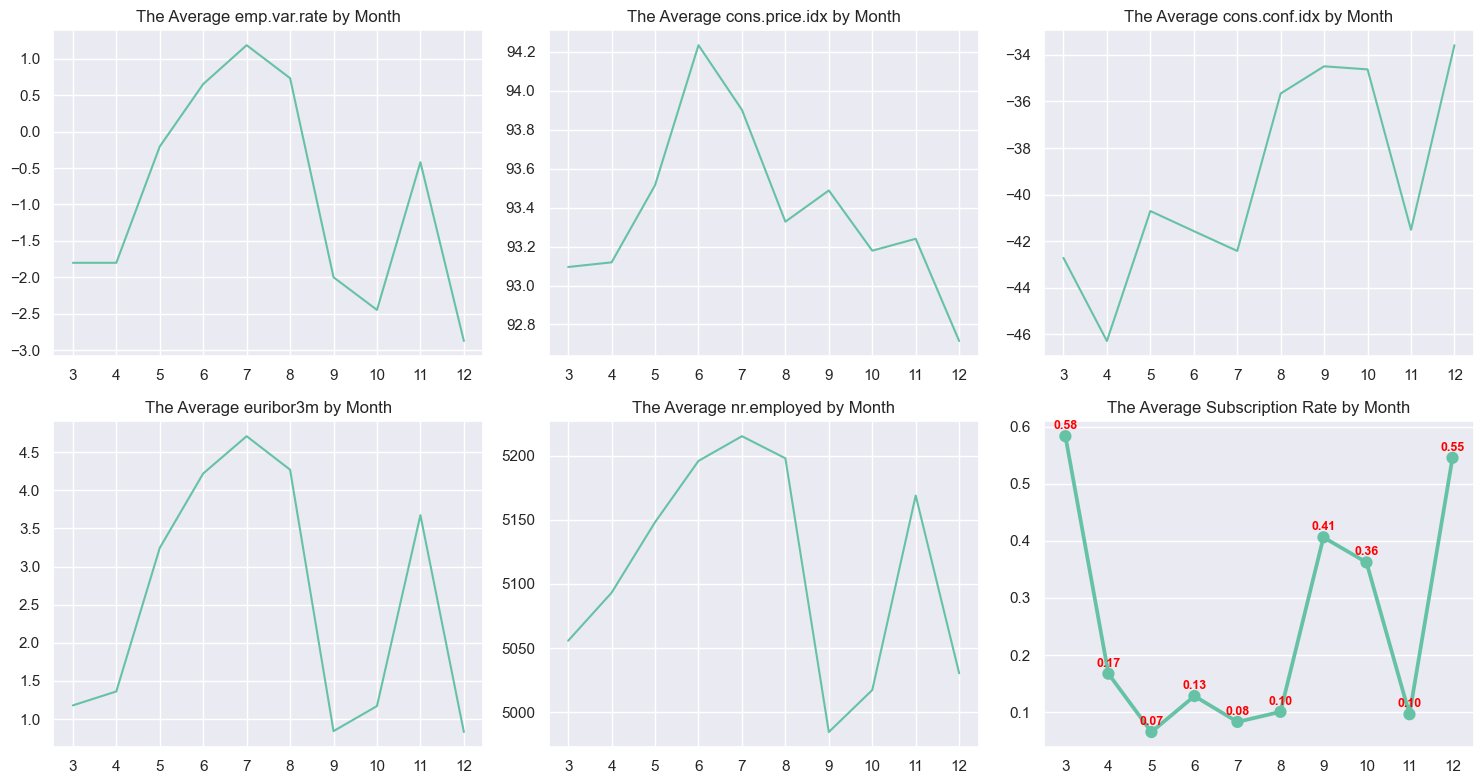

In [16]:
# plot the time series plot of month vs. socio-economic variables
vars = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes_flat = axes.flatten()
for i, var in enumerate(vars):
    sns.lineplot(x='month', y=var, data=data, ax=axes_flat[i],
                 ci=None, estimator='mean')
    axes_flat[i].set_title(f'The Average {var} by Month')
    axes_flat[i].set_xlabel('')
    axes_flat[i].set_ylabel('')
    # show all xticks
    axes_flat[i].set_xticks(data['month'].unique())

sns.pointplot(x='month', y='subscribed', data=data, ax=axes_flat[-1], ci=None)
axes_flat[-1].set_title('The Average Subscription Rate by Month')
axes_flat[-1].set_ylabel('')
axes_flat[-1].set_xlabel('')
# add the aggregated value to the pointplot as annotation
mean = data.groupby('month')['subscribed'].mean()
for j, mean in enumerate(mean):
    axes_flat[-1].annotate(f'{mean:.2f}', xy=(j, mean), xytext=(0, 5),
                            textcoords='offset points', ha='center',
                            color='red', size=9, weight='bold')

plt.tight_layout()
plt.show()

Binning of Age:  
Exact numbers are less relevant than the general magnitude of the value

In [17]:
# transform age to age range
data['age_range'] = pd.cut(data['age'],
                           bins=[-np.inf, 30, 40, 50, np.inf],
                           labels=['age <= 30', 'age 30-40', 'age 40-50', 'age > 50'])
data[['age', 'age_range']].sample(10)

,age,age_range
1800,37,age 30-40
2715,33,age 30-40
10,25,age <= 30
1839,33,age 30-40
3682,53,age > 50
2128,53,age > 50
2537,53,age > 50
1544,41,age 40-50
384,39,age 30-40
3263,42,age 40-50


In [18]:
# transform month back to categorical variable
data['month'] = data['month'].astype('category')

In [19]:
# define a function to plot the countplot and pointplot of the subscription by a categorical variable
def plot_count_point(col):
    """
    Plot the countplot and pointplot of the subscription by a categorical variable.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    order = list(data[col].value_counts().sort_values(ascending=False).index)
    sns.countplot(x=col, data=data, width=0.5, order=order, ax=axes[0])
    axes[0].set_title(f'Distribution of {col}')
    axes[0].set_xlabel('')
    axes[0].set_xticklabels(labels=order, rotation=45)

    sns.pointplot(x=col, y='subscribed', data=data, ci=None, order=order, ax=axes[1])
    axes[1].set_title(f'The Average Subscription Rate by {col}')
    axes[1].set_xlabel('')
    axes[1].set_xticklabels(labels=order, rotation=45)

    # add the aggregated value to the pointplot as annotation
    mean = data.groupby(col)['subscribed'].mean().reindex(order)
    for i, mean in enumerate(mean):
        axes[1].annotate(f'{mean:.3f}', xy=(i, mean), xytext=(0, 5),
                    textcoords='offset points', ha='center',
                    color='black', size=8, weight='bold')

    plt.tight_layout()
    plt.show()

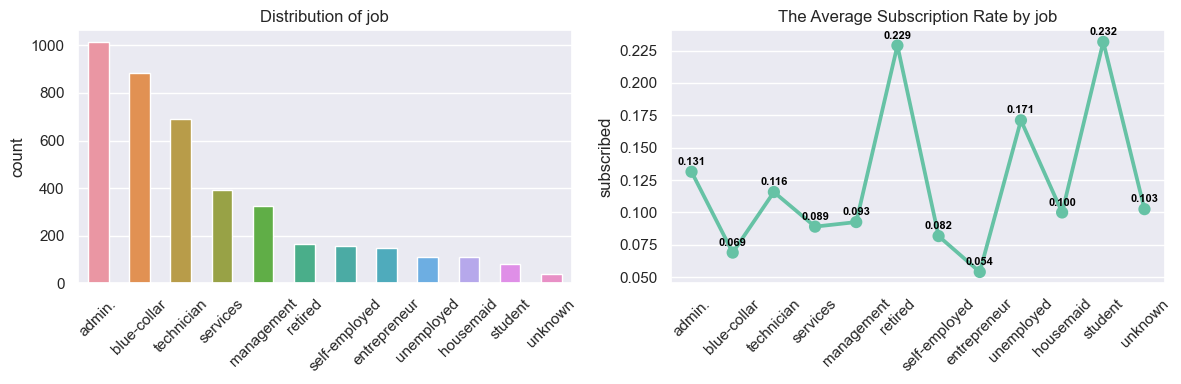

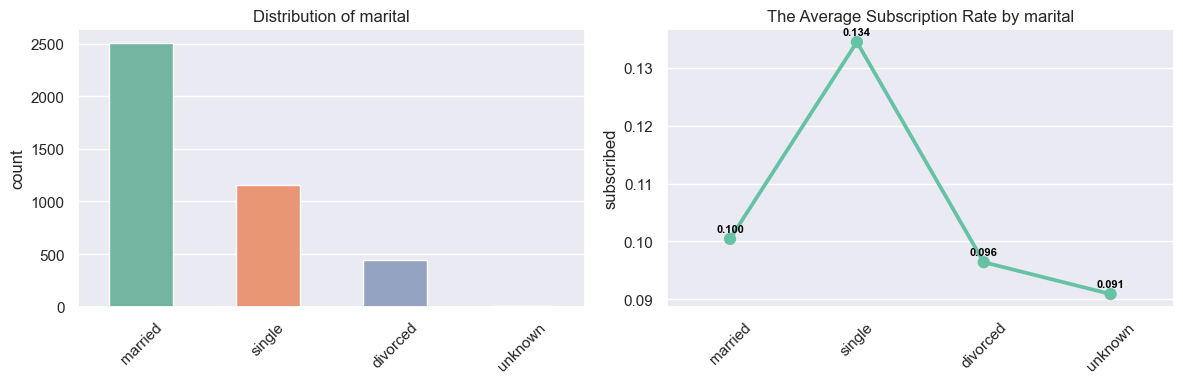

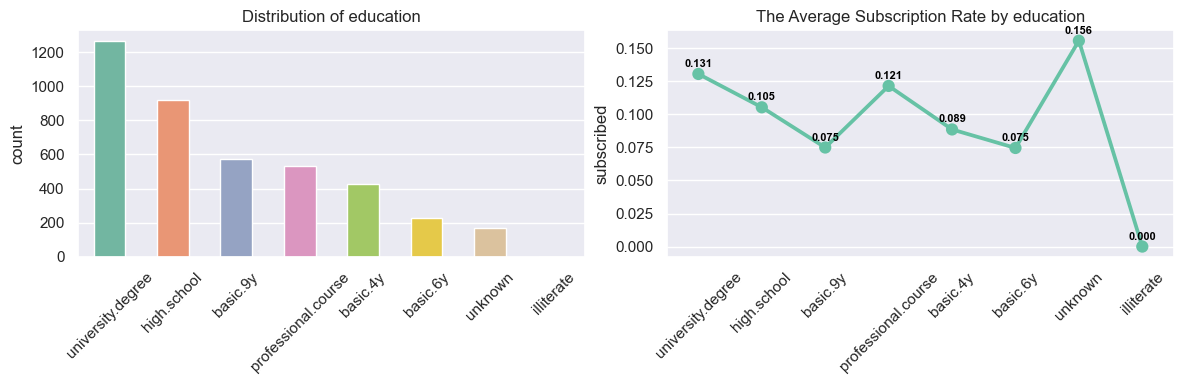

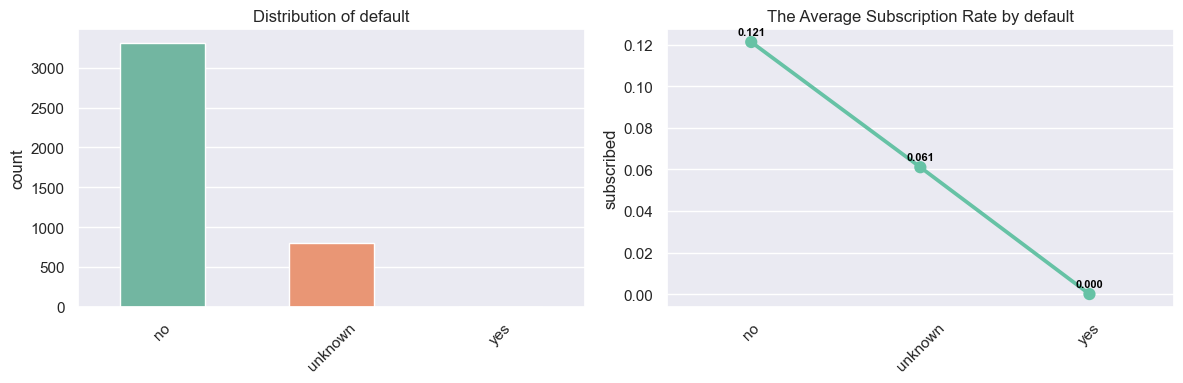

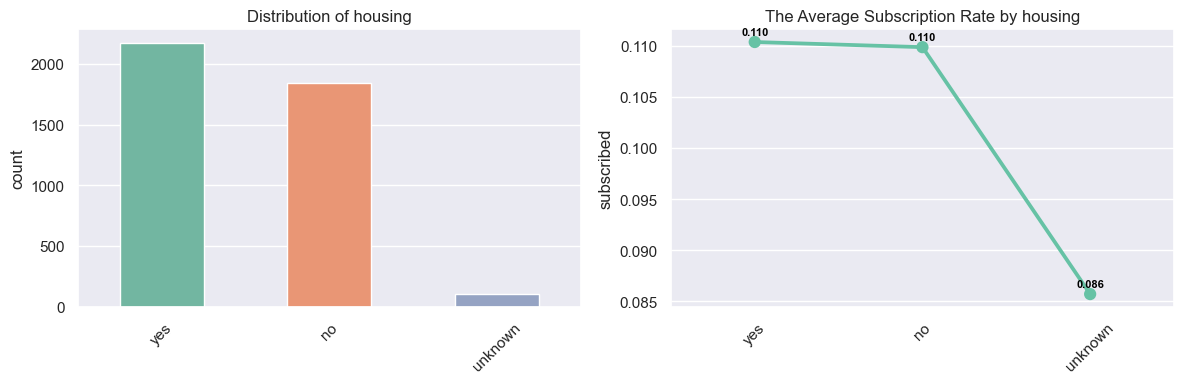

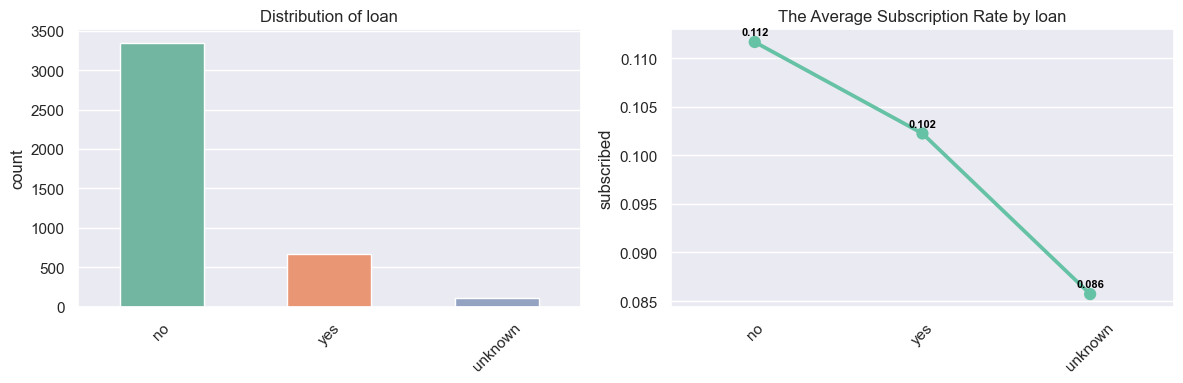

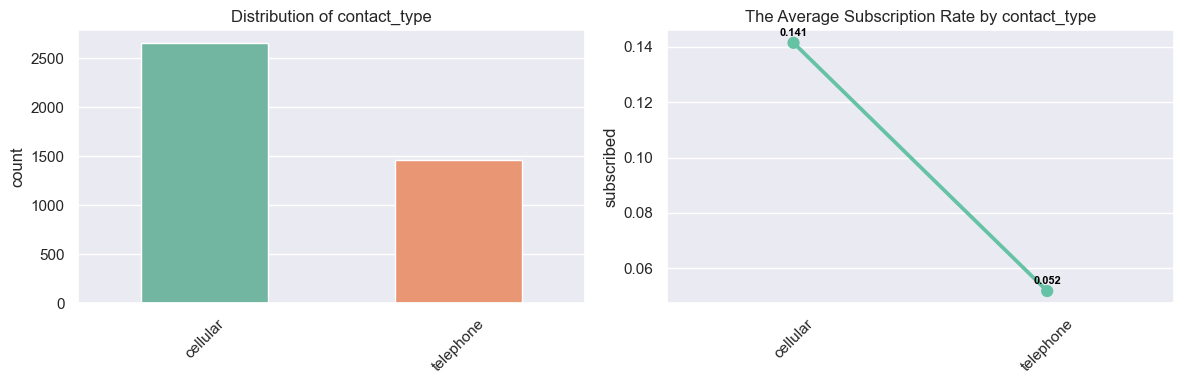

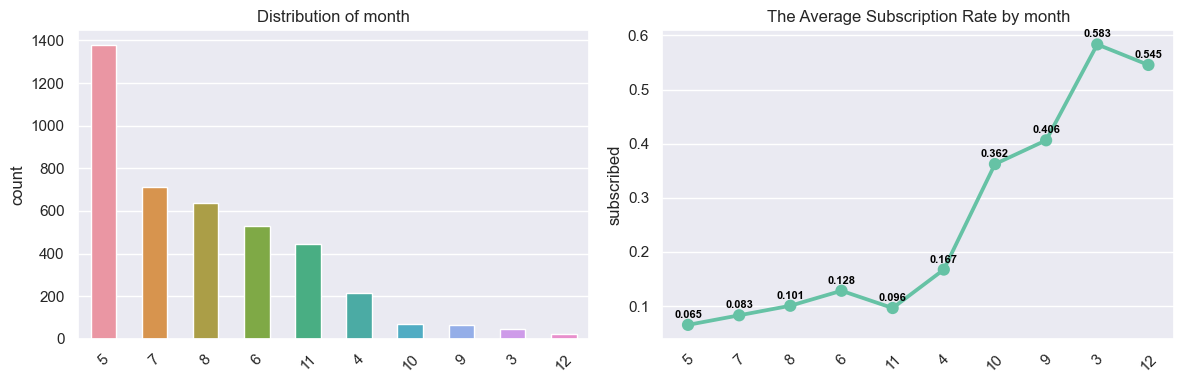

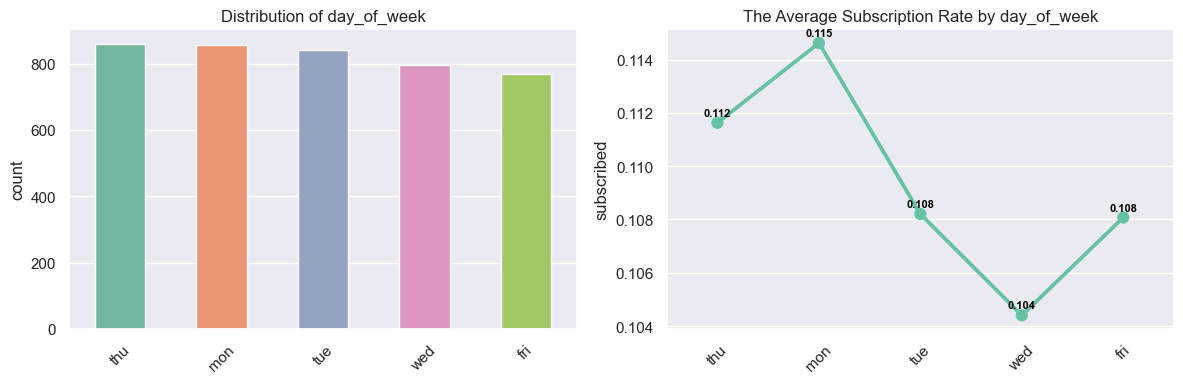

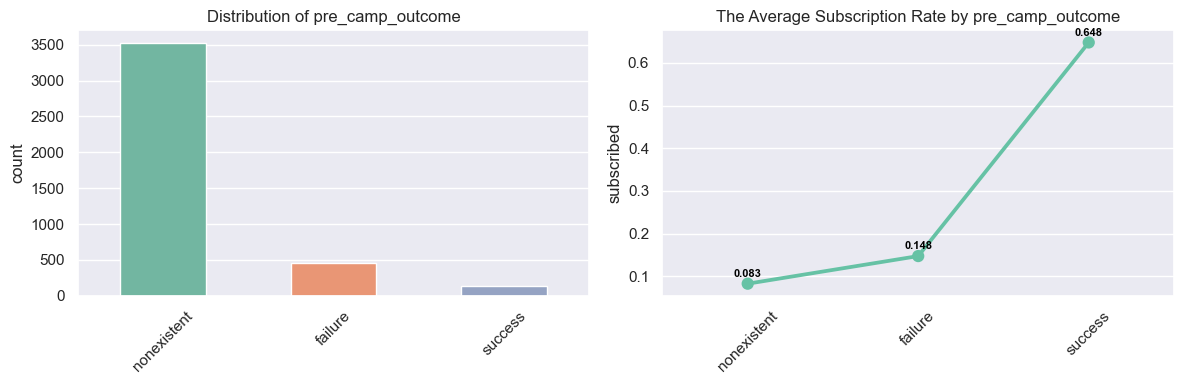

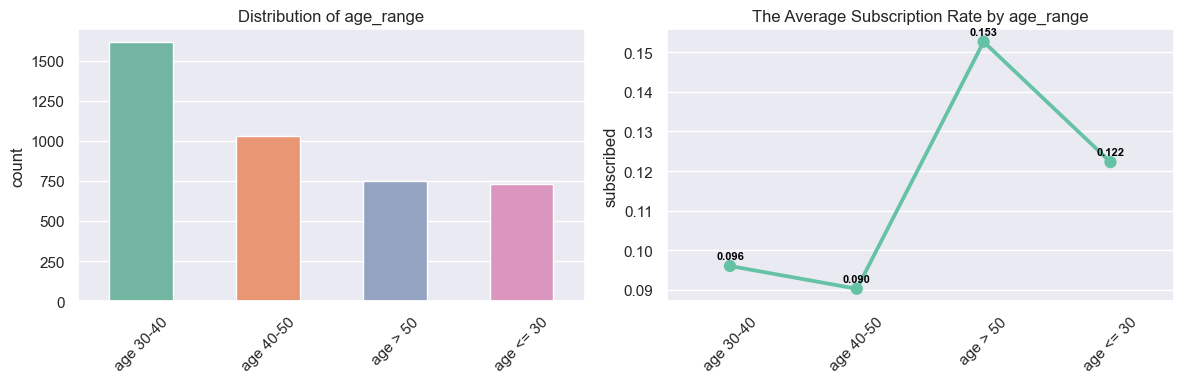

In [20]:
# plot the countplot and pointplot of the subscription by categorical variables
cat_cols = data.select_dtypes(include=['object','category']).columns
for col in cat_cols:
    plot_count_point(col)

In [21]:
# check the data
data.head()

,age,job,marital,education,default,housing,loan,contact_type,month,day_of_week,duration,camp_nr_contacts,pre_camp_nr_contacts,pre_camp_outcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed,age_range
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,5,fri,487,2,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0,age <= 30
1,39,services,single,high.school,no,no,no,telephone,5,fri,346,4,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0,age 30-40
2,25,services,married,high.school,no,yes,no,telephone,6,wed,227,1,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0,age <= 30
3,38,services,married,basic.9y,no,unknown,unknown,telephone,6,fri,17,3,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0,age 30-40
4,47,admin.,married,university.degree,no,yes,no,cellular,11,mon,58,1,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0,age 40-50


In [22]:
# drop the age_range and duration columns
data = data.drop(['age_range', 'duration'], axis=1)
data.head()

,age,job,marital,education,default,housing,loan,contact_type,month,day_of_week,camp_nr_contacts,pre_camp_nr_contacts,pre_camp_outcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,5,fri,2,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,5,fri,4,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,6,wed,1,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,6,fri,3,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,11,mon,1,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


In [23]:
data = data.drop('emp.var.rate', axis=1)

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
seed = 1

In [25]:
# Split the data into two DataFrames: X (features) and y (target variable)
y = data['subscribed']
X = data.drop(columns='subscribed', axis=1)

In [26]:
# dummy encoding the features
X_dummy = pd.get_dummies(X, drop_first=True)

# Split the data into train and test subsets and stratified sampling the test data size to be 30%
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.3, random_state=seed, stratify=y)

# Standardize the data
scaler_standard = StandardScaler()
X_train = scaler_standard.fit_transform(X_train)
X_test = scaler_standard.transform(X_test)

In [27]:
# set up the models and cross validation
kf = KFold(n_splits=5, random_state=seed, shuffle=True)
gnb = GaussianNB()
lr = LogisticRegression(random_state=seed)
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(random_state=seed)
rf = RandomForestClassifier(random_state=seed)
svc = SVC(random_state=seed, probability=True)
models = [gnb, lr, knn, tree, rf, svc]

In [28]:
# cross validation
cv_results = pd.DataFrame(columns=['model', 'cv_accuracy'])
for model in models:
    cv_results_accuracy = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    cv_results = pd.concat([cv_results,
                            pd.DataFrame({
                                'model': [model.__class__.__name__],
                                'cv_accuracy': [cv_results_accuracy.mean()]
                                })
                            ])

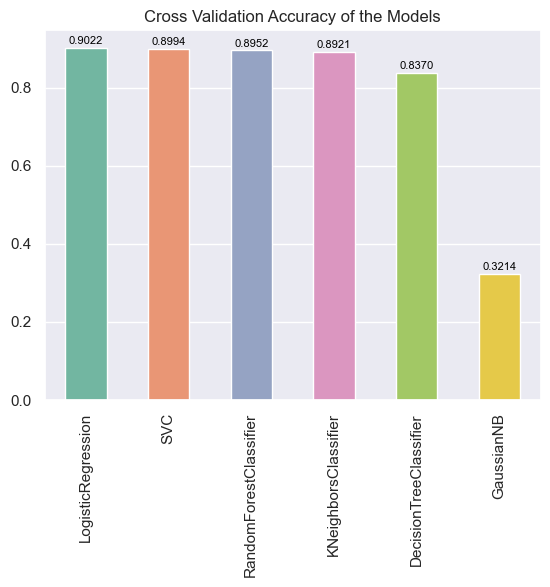

In [29]:
# plot the cross validation accuracy of the models
cv_results = cv_results.sort_values(by='cv_accuracy', ascending=False).reset_index(drop=True)
sns.barplot(x='model', y='cv_accuracy', data=cv_results, width=0.5)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('')
plt.title('Cross Validation Accuracy of the Models')

# add annotation to the barplot
for i, acc in enumerate(cv_results['cv_accuracy']):
    plt.annotate(f'{acc:.4f}', xy=(i, acc), xytext=(0, 3),
                 textcoords='offset points', ha='center',
                 color='black', size=8)

plt.show()

In [30]:
# fit the models and predict
# print the classification report of each model
# construct a dataframe to store the classification report of the models
report_data = []
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f'Classification Report of {model.__class__.__name__}:')
    print(classification_report(y_test, y_pred))
    print('------------------------------------------------------------')
    
    report = classification_report(y_test, y_pred, output_dict=True)
    model_name = model.__class__.__name__
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']

    report_data.append({'model': model_name, 'accuracy': accuracy,
                        'precision': precision, 'recall': recall, 'f1-score': f1_score})

report = pd.DataFrame(report_data)
report = report.sort_values(by='accuracy', ascending=False).reset_index(drop=True)

Classification Report of GaussianNB:
              precision    recall  f1-score   support

           0       0.97      0.09      0.17      1101
           1       0.12      0.98      0.21       135

    accuracy                           0.19      1236
   macro avg       0.54      0.54      0.19      1236
weighted avg       0.88      0.19      0.17      1236

------------------------------------------------------------
Classification Report of LogisticRegression:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1101
           1       0.57      0.27      0.37       135

    accuracy                           0.90      1236
   macro avg       0.74      0.62      0.66      1236
weighted avg       0.88      0.90      0.88      1236

------------------------------------------------------------
Classification Report of KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.91      0.96      0

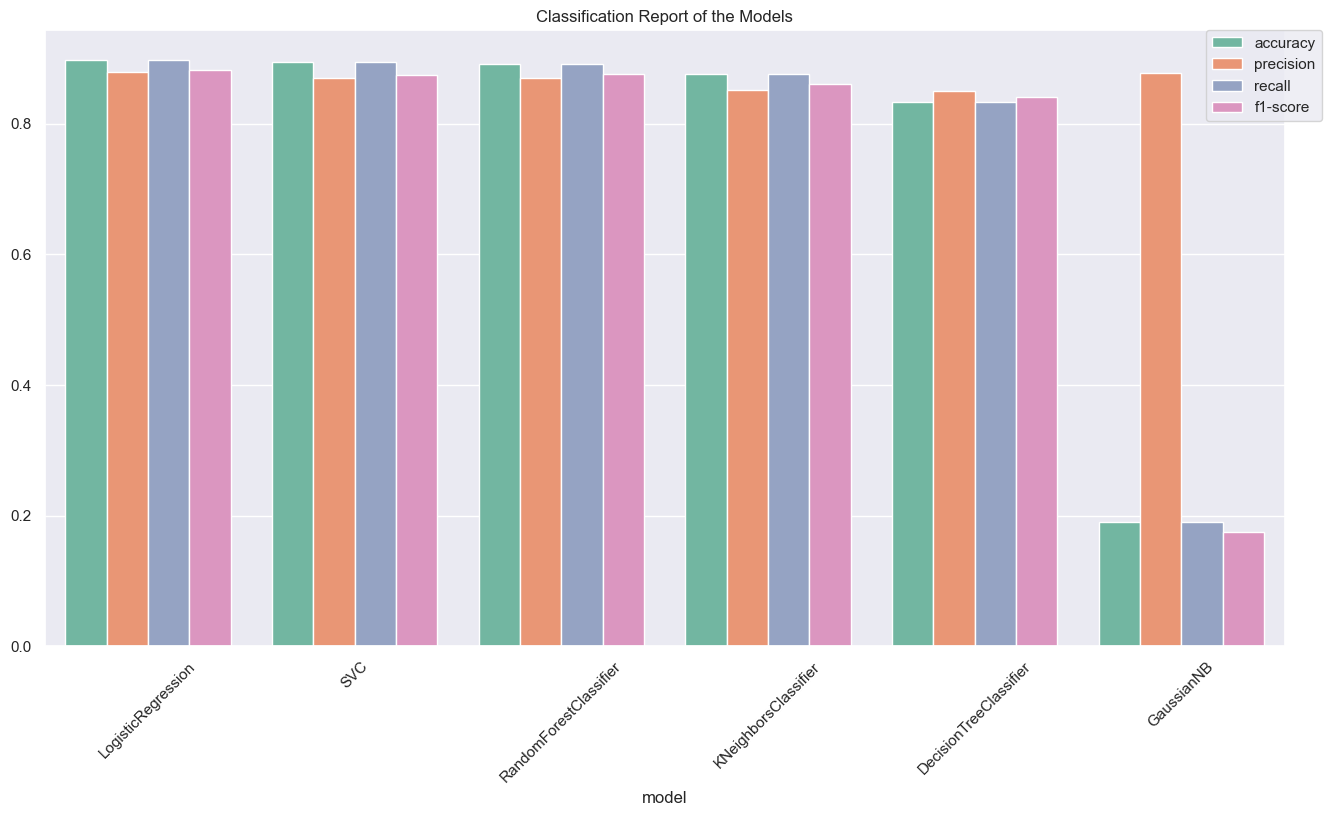

,model,accuracy,precision,recall,f1-score
0,LogisticRegression,0.898058,0.878402,0.898058,0.881789
1,SVC,0.894013,0.870025,0.894013,0.873930
2,RandomForestClassifier,0.890777,0.870263,0.890777,0.876309
3,KNeighborsClassifier,0.876214,0.852016,0.876214,0.861212
4,DecisionTreeClassifier,0.833333,0.849675,0.833333,0.840934
5,GaussianNB,0.190129,0.878325,0.190129,0.174824


In [31]:
# plot the stacked barplot of the classification report
report_melt = report.melt(id_vars='model', 
                          value_vars=['accuracy' ,'precision', 'recall', 'f1-score'])

fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x='model', y='value', hue='variable', data=report_melt, ax=ax, width=0.8)
ax.set_ylabel('')
ax.set_title('Classification Report of the Models')

# rotate the xticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# move the legend outside the plot
ax.legend(bbox_to_anchor=(1.03, 1), borderaxespad=0)

plt.show()

report